# Build `gold_prob` 

In [ ]:
import os
import pandas as pd 
import numpy as np

def parse_probs(val):
    if isinstance(val, str):
        return np.fromstring(val.strip("[]"), sep=" ")
    else:
        return np.array(val)

def get_gold_prob(row, probs_col):
    option_letters = ["A", "B", "C", "D"]
    gold_idx = option_letters.index(row["gold"])
    arr = parse_probs(row[probs_col])
    return arr[gold_idx]

def process_csv(file_path, out_dir):
    df = pd.read_csv(file_path)

    # اضافه کردن ستون‌ها
    df["gold_prob_noexp"] = df.apply(lambda r: get_gold_prob(r, "probs_noexp"), axis=1)
    df["gold_prob_exp"]   = df.apply(lambda r: get_gold_prob(r, "probs_exp"), axis=1)
    df["delta_gold_prob"] = df["gold_prob_exp"] - df["gold_prob_noexp"]

    # ذخیره در پوشه جدید (out_dir)
    os.makedirs(out_dir, exist_ok=True)
    base_name = os.path.basename(file_path)
    out_path = os.path.join(out_dir, base_name.replace(".csv", "_with_goldprob.csv"))
    df.to_csv(out_path, index=False)
    print(f"✅ ذخیره شد: {out_path}")

def process_all(root_dir, out_root="processed_results"):
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(subdir, file)
                # مسیر خروجی آینه‌ای (mirror) درست کن
                rel_path = os.path.relpath(subdir, root_dir)
                out_dir = os.path.join(out_root, rel_path)
                process_csv(file_path, out_dir)

# اجرای کلی
process_all("/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa", out_root="fa_with_goldprob")


✅ ذخیره شد: fa_with_goldprob/llama_4_maverik/eval_llama_4_maverik_masked_10_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/llama_4_maverik/eval_llama_4_maverik_masked_20_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/llama_4_maverik/eval_llama_4_maverik_masked_50_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/llama_4_maverik/eval_llama_4_maverik_masked_40_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/llama_4_maverik/eval_llama_4_maverik_masked_0_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/llama_4_maverik/eval_llama_4_maverik_masked_80_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/llama_4_maverik/eval_llama_4_maverik_masked_30_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/llama_4_maverik/eval_llama_4_maverik_masked_60_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/llama_4_maverik/eval_llama_4_maverik_masked_90_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/llama_4_maverik/eval_llama_4_maverik_masked_70_with_goldprob.csv
✅ ذخیره شد: fa_with_goldprob/cohere_r_command/eval_cohere_r_c

# Metrics_Function

In [3]:
import pandas as pd
import glob
import os

def compute_metrics(folder: str, prefix: str) -> pd.DataFrame:
    """
    Compute accuracy, sufficiency, and similarities for all CSVs in a folder
    that start with the given prefix.
    
    Args:
        folder (str): Path to folder containing eval CSV files.
        prefix (str): Prefix of the filenames (e.g. 'eval_cohere_r_command_').
        
    Returns:
        pd.DataFrame: Summary table of metrics across versions.
    """
    files = sorted(glob.glob(os.path.join(folder, f"{prefix}*.csv")))
    results = []

    for f in files:
        print(f)
        version = os.path.splitext(os.path.basename(f))[0].split("_")[-3]
        df = pd.read_csv(f)

        # Accuracy with explanation
        acc_exp = df["is_correct_exp"].mean()

        # Accuracy without explanation (baseline)
        acc_noexp = df["is_correct_noexp"].mean() if "is_correct_noexp" in df else None

        # Sufficiency (mean prob of correct answer given explanation)
        suff = df["gold_prob_exp"].mean()

        # Similarities (may not exist in baseline)
        sim = df["similarity_with_base"].mean() if "similarity_with_base" in df else None
        sim_clean = df["similarity_with_base_clean"].mean() if "similarity_with_base_clean" in df else None

        results.append({
            "version": version,
            "accuracy_exp": acc_exp,
            "accuracy_noexp": acc_noexp,
            "sufficiency": suff,
            "similarity": sim,
            "similarity_clean": sim_clean
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="version").reset_index(drop=True)
    return results_df


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np

# Set publication-ready style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

def plot_metrics(results_df, model_name="Model"):
    """
    Create publication-ready plots for accuracy, sufficiency, and similarity metrics.
    
    Args:
        results_df (pd.DataFrame): Results dataframe with version and metric columns
        model_name (str): Name of the model for the title
    """
    results_df["version"] = results_df["version"].astype(int)
    baseline_df = results_df[results_df["version"] == 0]
    other_df = results_df[results_df["version"] != 0].sort_values(by="version", ascending=False)
    plot_df = pd.concat([baseline_df, other_df])
    
    # Define consistent styling
    display_labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    x_pos = range(len(plot_df))
    
    # Create figure with publication-ready dimensions
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), facecolor='white')
    fig.patch.set_facecolor('white')
    
    # Color scheme for consistency
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    # Plot 1: Accuracy
    axs[0].plot(x_pos, plot_df["accuracy_exp"], marker="o", linewidth=2.5, 
                markersize=8, color=colors[0], label="With Explanation", zorder=3)
    if "accuracy_noexp" in plot_df.columns:
        axs[0].plot(x_pos, plot_df["accuracy_noexp"], marker="s", linewidth=2.5, 
                    markersize=8, linestyle="--", color=colors[1], 
                    label="Without Explanation", zorder=3)
    
    axs[0].set_title("Model Accuracy", fontsize=14, fontweight='bold', pad=15)
    axs[0].set_ylabel("Accuracy Score", fontsize=12)
    axs[0].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    axs[0].legend(frameon=True, fancybox=True, shadow=True, loc='best')
    axs[0].set_ylim(bottom=min(plot_df["accuracy_exp"]) * 0.95)
    
    # Plot 2: Sufficiency
    axs[1].plot(x_pos, plot_df["sufficiency"], marker="^", linewidth=2.5, 
                markersize=8, color=colors[2], zorder=3)
    axs[1].set_title("Explanation Sufficiency", fontsize=14, fontweight='bold', pad=15)
    axs[1].set_ylabel("Sufficiency Score", fontsize=12)
    axs[1].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    axs[1].set_ylim(bottom=min(plot_df["sufficiency"]) * 0.95)
    
    # Plot 3: Similarity
    if "similarity" in plot_df.columns:
        axs[2].plot(x_pos, plot_df["similarity"], marker="o", linewidth=2.5, 
                    markersize=8, color='#C73E1D', label="Original", zorder=3)
    if "similarity_clean" in plot_df.columns:
        axs[2].plot(x_pos, plot_df["similarity_clean"], marker="^", linewidth=2.5, 
                    markersize=8, color='#7209B7', label="Cleaned", zorder=3)
    
    axs[2].set_title("Output Similarity", fontsize=14, fontweight='bold', pad=15)
    axs[2].set_ylabel("Similarity Score", fontsize=12)
    axs[2].grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    axs[2].legend(frameon=True, fancybox=True, shadow=True, loc='best')
    if "similarity" in plot_df.columns:
        axs[2].set_ylim(bottom=min(plot_df["similarity"]) * 0.95)
    
    # Common styling for all subplots
    for i, ax in enumerate(axs):
        ax.set_xticks(x_pos)
        ax.set_xticklabels(display_labels, rotation=45, ha='right', fontsize=11)
        ax.set_xlabel("Constraint Level", fontsize=12, fontweight='bold')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.8)
        ax.spines['bottom'].set_linewidth(0.8)
        
        # Add subtle background shading for baseline
        ax.axvspan(-0.5, 0.5, alpha=0.1, color='gray', zorder=1)
    
    # Main title
    fig.suptitle(f"Performance Metrics Evaluation: {model_name}", 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.15)
    plt.show()


def plot_multi_models(dfs: dict, metric: str, title: str, save_path=None):
    """
    Create publication-ready multi-model comparison plot.
    
    Args:
        dfs (dict): Dictionary of model names and their dataframes
        metric (str): Metric column name to plot
        title (str): Plot title
        save_path (str, optional): Path to save the figure
    """
    # Create publication-ready figure
    plt.figure(figsize=(12, 7), facecolor='white')
    
    # Enhanced color palette for multiple models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # Line styles for variety
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    display_labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    
    for i, (model_name, df) in enumerate(dfs.items()):
        df = df.copy()
        df["version"] = df["version"].astype(int)
        baseline_df = df[df["version"] == 0]
        other_df = df[df["version"] != 0].sort_values(by="version", ascending=False)
        plot_df = pd.concat([baseline_df, other_df])
        
        x_pos = range(len(plot_df))
        
        plt.plot(x_pos, plot_df[metric], 
                marker=markers[i % len(markers)], 
                linewidth=3, 
                markersize=9,
                color=colors[i % len(colors)],
                linestyle=line_styles[i % len(line_styles)],
                label=model_name,
                zorder=3)
    
    # Styling
    plt.xticks(x_pos, display_labels, rotation=45, ha='right', fontsize=12)
    plt.xlabel("Constraint Level", fontsize=14, fontweight='bold')
    plt.ylabel(f"{metric.replace('_', ' ').title()} Score", fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Enhanced legend
    plt.legend(frameon=True, fancybox=True, shadow=True, 
              bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
    
    # Grid and styling
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    
    # Highlight baseline region
    plt.axvspan(-0.5, 0.5, alpha=0.1, color='gray', zorder=1)
    
    # Removed the bottom constraint level annotation text
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12, right=0.85)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    plt.show()


def plot_heatmap_comparison(dfs: dict, metrics: list, title: str = "Model Performance Heatmap"):
    """
    Create a heatmap comparison of multiple metrics across models and constraint levels.
    
    Args:
        dfs (dict): Dictionary of model names and their dataframes
        metrics (list): List of metric column names
        title (str): Heatmap title
    """
    # Prepare data for heatmap
    heatmap_data = []
    model_names = []
    
    display_labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    
    for model_name, df in dfs.items():
        df = df.copy()
        df["version"] = df["version"].astype(int)
        baseline_df = df[df["version"] == 0]
        other_df = df[df["version"] != 0].sort_values(by="version", ascending=False)
        plot_df = pd.concat([baseline_df, other_df])
        
        for metric in metrics:
            if metric in plot_df.columns:
                heatmap_data.append(plot_df[metric].values)
                model_names.append(f"{model_name} - {metric.replace('_', ' ').title()}")
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, len(model_names) * 0.6), facecolor='white')
    
    heatmap_array = np.array(heatmap_data)
    im = ax.imshow(heatmap_array, cmap='RdYlGn', aspect='auto', interpolation='nearest')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Performance Score', fontsize=12, fontweight='bold')
    
    # Labels
    ax.set_xticks(range(len(display_labels)))
    ax.set_xticklabels(display_labels, rotation=45, ha='right')
    ax.set_yticks(range(len(model_names)))
    ax.set_yticklabels(model_names, fontsize=10)
    
    ax.set_xlabel("Constraint Level", fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Add value annotations
    for i in range(len(model_names)):
        for j in range(len(display_labels)):
            text = ax.text(j, i, f'{heatmap_array[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## Claude

In [4]:
claude_df = compute_metrics("claude", "eval_claude_3_haiku_")
claude_df

claude/eval_claude_3_haiku_fa_0_with_goldprob.csv
claude/eval_claude_3_haiku_fa_10_with_goldprob.csv
claude/eval_claude_3_haiku_fa_20_with_goldprob.csv
claude/eval_claude_3_haiku_fa_30_with_goldprob.csv
claude/eval_claude_3_haiku_fa_40_with_goldprob.csv
claude/eval_claude_3_haiku_fa_50_with_goldprob.csv
claude/eval_claude_3_haiku_fa_60_with_goldprob.csv
claude/eval_claude_3_haiku_fa_70_with_goldprob.csv
claude/eval_claude_3_haiku_fa_80_with_goldprob.csv
claude/eval_claude_3_haiku_fa_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean
0,0,0.783805,0.478497,0.747764,None,NaN
1,10,0.688493,0.478497,0.651099,None,0.641761
2,20,0.719101,0.478497,0.685721,None,0.746146
3,30,0.745060,0.478497,0.708011,None,0.796191
4,40,0.749322,0.478497,0.716315,None,0.826505
5,50,0.750872,0.478497,0.720418,None,0.844635
6,60,0.760558,0.478497,0.724539,None,0.851756
7,70,0.765595,0.478497,0.728309,None,0.854943
8,80,0.765207,0.478497,0.729720,None,0.862874
9,90,0.764820,0.478497,0.728880,None,0.868333


## GPT

In [5]:
gpt_df = compute_metrics("gpt-4o-mini", "eval_gpt_4o_mini_")
gpt_df

gpt-4o-mini/eval_gpt_4o_mini_fa_0_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_10_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_20_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_30_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_40_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_50_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_60_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_70_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_80_with_goldprob.csv
gpt-4o-mini/eval_gpt_4o_mini_fa_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean
0,0,0.826036,0.479272,0.791861,None,NaN
1,10,0.645486,0.479272,0.607502,None,0.584329
2,20,0.679194,0.479272,0.635490,None,0.676961
3,30,0.710190,0.479272,0.668659,None,0.742607
4,40,0.731112,0.479272,0.688366,None,0.794435
5,50,0.749709,0.479272,0.703853,None,0.831390
6,60,0.753584,0.479272,0.714209,None,0.855248
7,70,0.767532,0.479272,0.726096,None,0.872703
8,80,0.775668,0.479272,0.736458,None,0.888897
9,90,0.782255,0.479272,0.744429,None,0.902828


## Cohere

In [6]:
cohere_df = compute_metrics("cohere", "eval_cohere_r_command_")
cohere_df

cohere/eval_cohere_r_command_fa_0_with_goldprob.csv
cohere/eval_cohere_r_command_fa_10_with_goldprob.csv
cohere/eval_cohere_r_command_fa_20_with_goldprob.csv
cohere/eval_cohere_r_command_fa_30_with_goldprob.csv
cohere/eval_cohere_r_command_fa_40_with_goldprob.csv
cohere/eval_cohere_r_command_fa_50_with_goldprob.csv
cohere/eval_cohere_r_command_fa_60_with_goldprob.csv
cohere/eval_cohere_r_command_fa_70_with_goldprob.csv
cohere/eval_cohere_r_command_fa_80_with_goldprob.csv
cohere/eval_cohere_r_command_fa_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean
0,0,0.692367,0.478497,0.661227,None,NaN
1,10,0.613328,0.478497,0.576517,None,0.525559
2,20,0.631926,0.478497,0.601882,None,0.656978
3,30,0.648586,0.478497,0.617286,None,0.729514
4,40,0.672220,0.478497,0.633912,None,0.777698
5,50,0.666796,0.478497,0.635008,None,0.807805
6,60,0.670670,0.478497,0.637668,None,0.827879
7,70,0.675707,0.478497,0.644664,None,0.845101
8,80,0.683069,0.478497,0.649870,None,0.860100
9,90,0.680356,0.478497,0.648612,None,0.873420


## LLama

In [7]:
llama_df = compute_metrics("llama", "eval_llama_4_maverik_")
llama_df

llama/eval_llama_4_maverik_masked_0_with_goldprob.csv
llama/eval_llama_4_maverik_masked_10_with_goldprob.csv
llama/eval_llama_4_maverik_masked_20_with_goldprob.csv
llama/eval_llama_4_maverik_masked_30_with_goldprob.csv
llama/eval_llama_4_maverik_masked_40_with_goldprob.csv
llama/eval_llama_4_maverik_masked_50_with_goldprob.csv
llama/eval_llama_4_maverik_masked_60_with_goldprob.csv
llama/eval_llama_4_maverik_masked_70_with_goldprob.csv
llama/eval_llama_4_maverik_masked_80_with_goldprob.csv
llama/eval_llama_4_maverik_masked_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean
0,0,0.849671,0.478497,0.806687,None,NaN
1,10,0.653623,0.478497,0.612349,None,0.547995
2,20,0.704766,0.478497,0.657773,None,0.674266
3,30,0.735374,0.478497,0.688907,None,0.747198
4,40,0.755909,0.478497,0.708394,None,0.790834
5,50,0.771406,0.478497,0.722975,None,0.817820
6,60,0.777606,0.478497,0.730638,None,0.837806
7,70,0.773731,0.478497,0.735538,None,0.850494
8,80,0.791166,0.478497,0.746862,None,0.861219
9,90,0.796203,0.478497,0.749993,None,0.870873


## Deepseek

In [8]:
deepseek_df = compute_metrics("deepseek", "eval_deepseek_v3.1_")
deepseek_df

deepseek/eval_deepseek_v3.1_0_with_goldprob.csv
deepseek/eval_deepseek_v3.1_10_with_goldprob.csv
deepseek/eval_deepseek_v3.1_20_with_goldprob.csv
deepseek/eval_deepseek_v3.1_30_with_goldprob.csv
deepseek/eval_deepseek_v3.1_40_with_goldprob.csv
deepseek/eval_deepseek_v3.1_50_with_goldprob.csv
deepseek/eval_deepseek_v3.1_60_with_goldprob.csv
deepseek/eval_deepseek_v3.1_70_with_goldprob.csv
deepseek/eval_deepseek_v3.1_80_with_goldprob.csv
deepseek/eval_deepseek_v3.1_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean
0,0,0.802402,0.478497,0.766077,None,NaN
1,10,0.667571,0.478497,0.621031,None,0.570013
2,20,0.693142,0.478497,0.649168,None,0.654810
3,30,0.717939,0.478497,0.670463,None,0.707658
4,40,0.728787,0.478497,0.685542,None,0.743207
5,50,0.742348,0.478497,0.694888,None,0.772465
6,60,0.738473,0.478497,0.699196,None,0.789537
7,70,0.747385,0.478497,0.703200,None,0.805601
8,80,0.759008,0.478497,0.713849,None,0.820477
9,90,0.767532,0.478497,0.721202,None,0.834147


## Gemini

In [9]:
gemini_df = compute_metrics("gemini", "eval_gemini_2.0_flash_")
gemini_df

gemini/eval_gemini_2.0_flash_fa_0_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_10_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_20_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_30_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_40_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_50_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_60_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_70_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_80_with_goldprob.csv
gemini/eval_gemini_2.0_flash_fa_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean
0,0,0.820612,0.478497,0.780864,None,NaN
1,10,0.692755,0.478497,0.650338,None,0.557314
2,20,0.736149,0.478497,0.693264,None,0.692414
3,30,0.760558,0.478497,0.718593,None,0.768547
4,40,0.781480,0.478497,0.740963,None,0.807795
5,50,0.797365,0.478497,0.751521,None,0.831511
6,60,0.800852,0.478497,0.758141,None,0.845797
7,70,0.807826,0.478497,0.763811,None,0.857220
8,80,0.803177,0.478497,0.765482,None,0.866516
9,90,0.809764,0.478497,0.768477,None,0.873269


## Mistral

In [10]:
mistral_df = compute_metrics("mistral", "eval_mistral_small_3.1_")
mistral_df

mistral/eval_mistral_small_3.1_0_with_goldprob.csv
mistral/eval_mistral_small_3.1_10_with_goldprob.csv
mistral/eval_mistral_small_3.1_20_with_goldprob.csv
mistral/eval_mistral_small_3.1_30_with_goldprob.csv
mistral/eval_mistral_small_3.1_40_with_goldprob.csv
mistral/eval_mistral_small_3.1_50_with_goldprob.csv
mistral/eval_mistral_small_3.1_60_with_goldprob.csv
mistral/eval_mistral_small_3.1_70_with_goldprob.csv
mistral/eval_mistral_small_3.1_80_with_goldprob.csv
mistral/eval_mistral_small_3.1_90_with_goldprob.csv


,version,accuracy_exp,accuracy_noexp,sufficiency,similarity,similarity_clean
0,0,0.750484,0.478497,0.716347,None,NaN
1,10,0.624177,0.478497,0.584414,None,0.517561
2,20,0.658272,0.478497,0.618446,None,0.619578
3,30,0.674157,0.478497,0.641659,None,0.687024
4,40,0.693142,0.478497,0.649619,None,0.733356
5,50,0.698179,0.478497,0.660237,None,0.773433
6,60,0.701279,0.478497,0.667800,None,0.796232
7,70,0.717164,0.478497,0.673798,None,0.808734
8,80,0.707865,0.478497,0.673157,None,0.832841
9,90,0.721813,0.478497,0.687929,None,0.853676


# Multi_Models

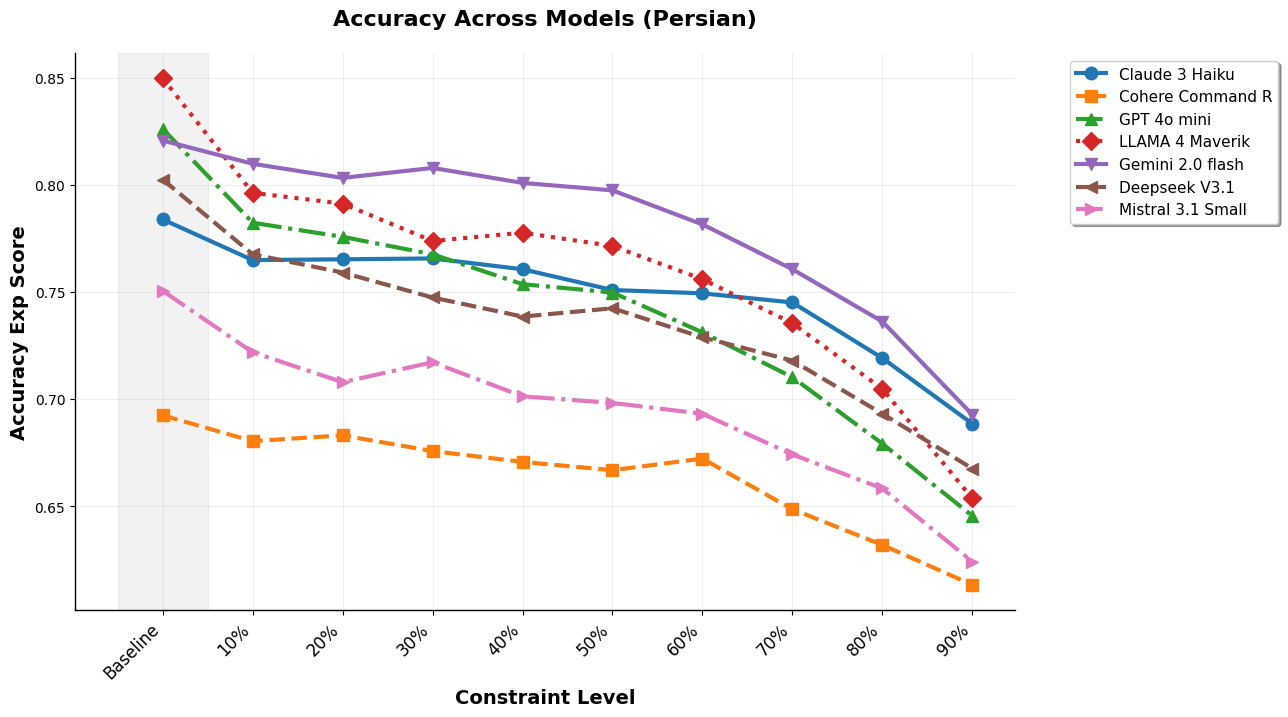

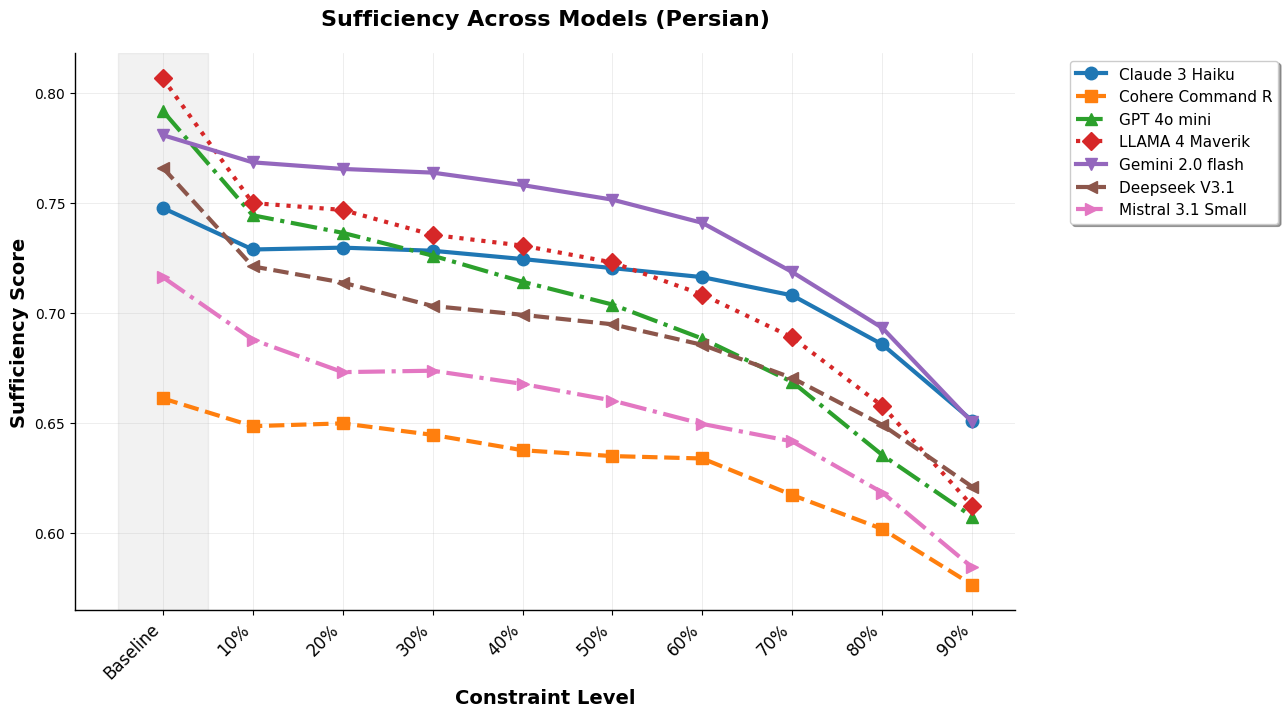

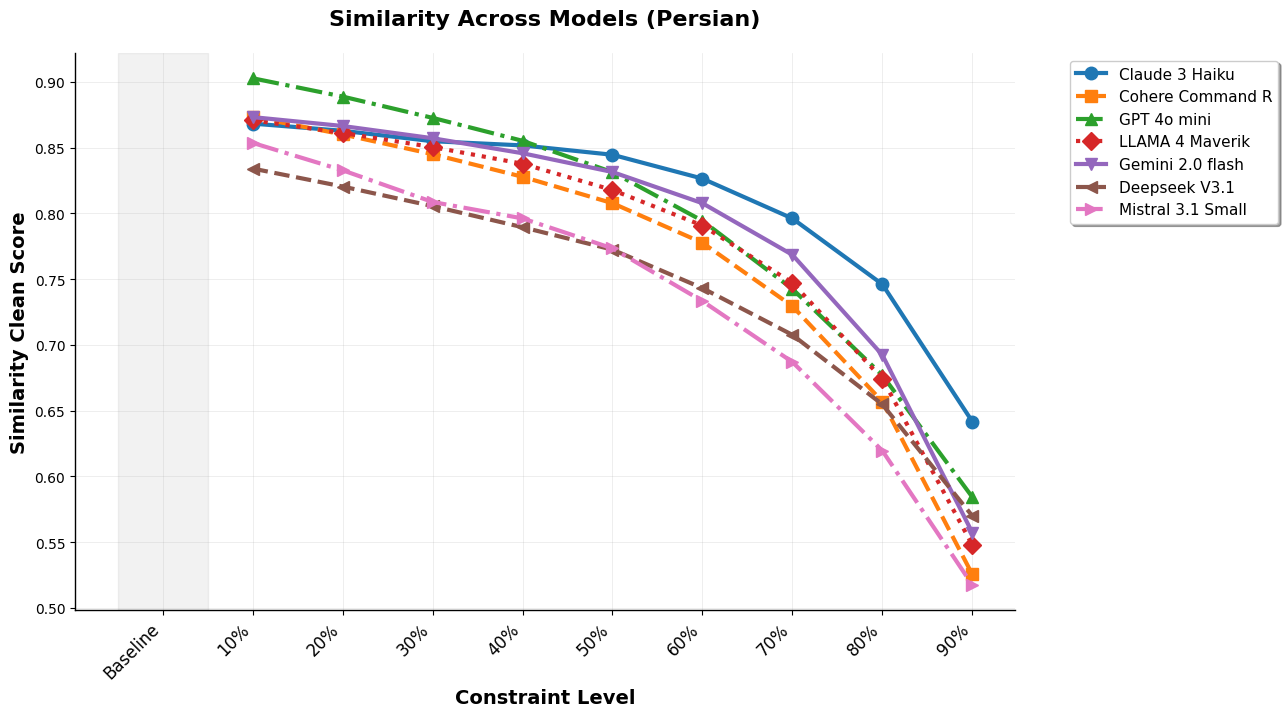

In [13]:
# دیکشنری از مدل‌ها
dfs = {
    "Claude 3 Haiku": claude_df,
    "Cohere Command R": cohere_df,
    "GPT 4o mini": gpt_df,
    "LLAMA 4 Maverik": llama_df,
    "Gemini 2.0 flash": gemini_df,
    "Deepseek V3.1": deepseek_df,
    "Mistral 3.1 Small": mistral_df,
}

# Accuracy
plot_multi_models(dfs, "accuracy_exp", "Accuracy Across Models (Persian)")

# Sufficiency
plot_multi_models(dfs, "sufficiency", "Sufficiency Across Models (Persian)")

# Similarity Clean
plot_multi_models(dfs, "similarity_clean", "Similarity Across Models (Persian)")

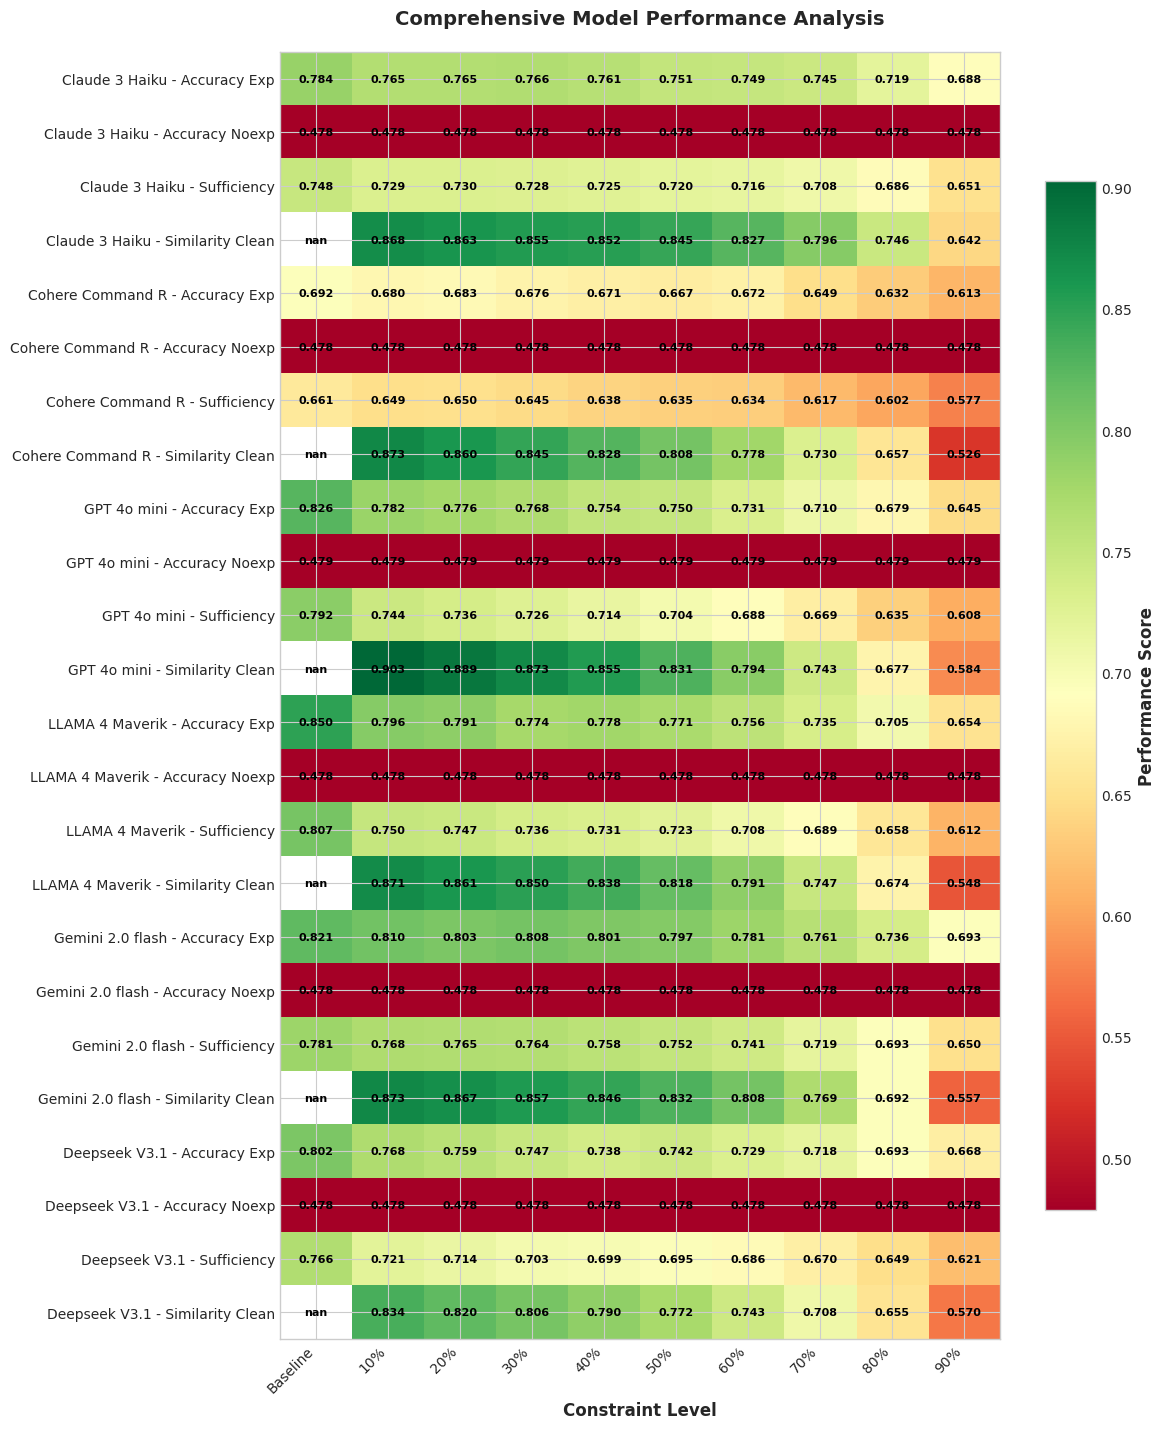

In [12]:
# Example 3: All available metrics
all_metrics = ["accuracy_exp", "accuracy_noexp", "sufficiency","similarity_clean"]
plot_heatmap_comparison(dfs, all_metrics, 
                       title="Comprehensive Model Performance Analysis")

# Other Visualization

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle

# Set professional style
plt.style.use('default')
sns.set_palette("Set2")

def plot_grouped_comparison(dfs: dict, metrics: list, title: str = "Model Performance Comparison"):
    """
    Create a clean grouped bar chart comparison across models and metrics.
    """
    display_labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    
    # Prepare data
    n_models = len(dfs)
    n_metrics = len(metrics)
    
    fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 8), facecolor='white')
    if n_metrics == 1:
        axes = [axes]
    
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#7209B7', '#2CA02C']
    
    for metric_idx, metric in enumerate(metrics):
        ax = axes[metric_idx]
        
        # Calculate bar positions
        bar_width = 0.8 / n_models
        x_pos = np.arange(len(display_labels))
        
        for model_idx, (model_name, df) in enumerate(dfs.items()):
            df = df.copy()
            df["version"] = df["version"].astype(int)
            baseline_df = df[df["version"] == 0]
            other_df = df[df["version"] != 0].sort_values(by="version", ascending=False)
            plot_df = pd.concat([baseline_df, other_df])
            
            if metric in plot_df.columns:
                values = plot_df[metric].values
                bar_positions = x_pos + (model_idx - n_models/2 + 0.5) * bar_width
                
                bars = ax.bar(bar_positions, values, bar_width, 
                             label=model_name, color=colors[model_idx % len(colors)],
                             alpha=0.8, edgecolor='white', linewidth=1)
                
                # Add value labels on bars
                for bar, value in zip(bars, values):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                           f'{value:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        ax.set_title(f"{metric.replace('_', ' ').title()}", fontsize=14, fontweight='bold', pad=20)
        ax.set_ylabel("Performance Score", fontsize=12)
        ax.set_xlabel("Constraint Level", fontsize=12)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(display_labels, rotation=45, ha='right')
        ax.grid(True, alpha=0.3, axis='y')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Highlight baseline
        ax.axvspan(-0.5, 0.5, alpha=0.1, color='gray', zorder=0)
        
        if metric_idx == 0:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, right=0.85)
    plt.show()


def plot_radar_comparison(dfs: dict, constraint_level: str = "50%", title: str = "Model Performance Radar"):
    """
    Create a radar chart comparing models at a specific constraint level.
    """
    # Map constraint level to version
    constraint_map = {"Baseline": 0, "10%": 10, "20%": 20, "30%": 30, "40%": 40, 
                     "50%": 50, "60%": 60, "70%": 70, "80%": 80, "90%": 90}
    
    version = constraint_map.get(constraint_level, 50)
    
    # Prepare data for radar chart
    metrics = ["accuracy_exp", "sufficiency", "similarity"]
    metric_labels = ["Accuracy", "Sufficiency", "Similarity"]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'), facecolor='white')
    
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#7209B7', '#2CA02C']
    
    for i, (model_name, df) in enumerate(dfs.items()):
        df = df.copy()
        df["version"] = df["version"].astype(int)
        
        # Get data for specific constraint level
        model_data = df[df["version"] == version]
        if model_data.empty:
            continue
            
        values = []
        for metric in metrics:
            if metric in model_data.columns:
                values.append(model_data[metric].iloc[0])
            else:
                values.append(0)
        
        values += values[:1]  # Complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=3, label=model_name, 
                color=colors[i % len(colors)], markersize=8)
        ax.fill(angles, values, alpha=0.25, color=colors[i % len(colors)])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels, fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=11)
    plt.title(f"{title} at {constraint_level} Constraint Level", 
              fontsize=14, fontweight='bold', pad=30)
    
    plt.tight_layout()
    plt.show()


def plot_performance_trends(dfs: dict, save_path: str = None):
    """
    Create an advanced multi-panel performance trends visualization.
    """
    metrics = ["accuracy_exp", "sufficiency", "similarity"]
    metric_titles = ["Model Accuracy", "Explanation Sufficiency", "Output Similarity"]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), facecolor='white')
    fig.patch.set_facecolor('white')
    
    display_labels = ["Baseline", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    markers = ['o', 's', '^', 'D', 'v', '<']
    
    # Plot individual metrics
    for metric_idx, (metric, metric_title) in enumerate(zip(metrics, metric_titles)):
        if metric_idx < 3:
            row, col = metric_idx // 2, metric_idx % 2
            ax = axes[row, col]
            
            for model_idx, (model_name, df) in enumerate(dfs.items()):
                df = df.copy()
                df["version"] = df["version"].astype(int)
                baseline_df = df[df["version"] == 0]
                other_df = df[df["version"] != 0].sort_values(by="version", ascending=False)
                plot_df = pd.concat([baseline_df, other_df])
                
                if metric in plot_df.columns:
                    x_pos = range(len(plot_df))
                    ax.plot(x_pos, plot_df[metric], 
                           marker=markers[model_idx % len(markers)], 
                           linewidth=3, markersize=8,
                           color=colors[model_idx % len(colors)],
                           label=model_name if metric_idx == 0 else "")
            
            ax.set_title(metric_title, fontsize=14, fontweight='bold')
            ax.set_ylabel("Score", fontsize=12)
            ax.set_xlabel("Constraint Level", fontsize=12)
            ax.set_xticks(range(len(display_labels)))
            ax.set_xticklabels(display_labels, rotation=45, ha='right')
            ax.grid(True, alpha=0.3)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            # Highlight baseline
            ax.axvspan(-0.5, 0.5, alpha=0.1, color='gray', zorder=0)
    
    # Combined performance score in the fourth subplot
    ax = axes[1, 1]
    for model_idx, (model_name, df) in enumerate(dfs.items()):
        df = df.copy()
        df["version"] = df["version"].astype(int)
        baseline_df = df[df["version"] == 0]
        other_df = df[df["version"] != 0].sort_values(by="version", ascending=False)
        plot_df = pd.concat([baseline_df, other_df])
        
        # Calculate combined score (average of available metrics)
        combined_scores = []
        for _, row in plot_df.iterrows():
            scores = []
            for metric in metrics:
                if metric in plot_df.columns and not pd.isna(row[metric]):
                    scores.append(row[metric])
            combined_scores.append(np.mean(scores) if scores else 0)
        
        x_pos = range(len(plot_df))
        ax.plot(x_pos, combined_scores, 
               marker=markers[model_idx % len(markers)], 
               linewidth=3, markersize=8,
               color=colors[model_idx % len(colors)],
               label=model_name)
    
    ax.set_title("Combined Performance Score", fontsize=14, fontweight='bold')
    ax.set_ylabel("Average Score", fontsize=12)
    ax.set_xlabel("Constraint Level", fontsize=12)
    ax.set_xticks(range(len(display_labels)))
    ax.set_xticklabels(display_labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvspan(-0.5, 0.5, alpha=0.1, color='gray', zorder=0)
    
    # Add legend to the first subplot
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    fig.suptitle("Comprehensive Model Performance Analysis", 
                 fontsize=18, fontweight='bold', y=0.95)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, right=0.85)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    plt.show()


def plot_delta_heatmap(dfs: dict, baseline_metric: str = "accuracy_exp", title: str = "Performance Change from Baseline"):
    """
    Create a heatmap showing performance changes relative to baseline.
    """
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
    
    delta_data = []
    model_names = list(dfs.keys())
    constraint_levels = ["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%"]
    
    for model_name, df in dfs.items():
        df = df.copy()
        df["version"] = df["version"].astype(int)
        
        baseline_value = df[df["version"] == 0][baseline_metric].iloc[0]
        
        model_deltas = []
        for version in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
            constraint_value = df[df["version"] == version][baseline_metric].iloc[0]
            delta = constraint_value - baseline_value
            model_deltas.append(delta)
        
        delta_data.append(model_deltas)
    
    delta_array = np.array(delta_data)
    
    # Create heatmap
    im = ax.imshow(delta_array, cmap='RdBu_r', aspect='auto', vmin=-0.1, vmax=0.1)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Performance Change from Baseline', fontsize=12, fontweight='bold')
    
    # Labels
    ax.set_xticks(range(len(constraint_levels)))
    ax.set_xticklabels(constraint_levels)
    ax.set_yticks(range(len(model_names)))
    ax.set_yticklabels(model_names, fontsize=12)
    
    ax.set_xlabel("Constraint Level", fontsize=14, fontweight='bold')
    ax.set_ylabel("Models", fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Add value annotations
    for i in range(len(model_names)):
        for j in range(len(constraint_levels)):
            value = delta_array[i, j]
            color = 'white' if abs(value) > 0.05 else 'black'
            ax.text(j, i, f'{value:+.3f}', ha="center", va="center", 
                   color=color, fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# LONG DF 

In [50]:
import pandas as pd

all_dfs = []
for model_name, df in dfs.items():
    # keep only needed columns
    sub = df[["version", "accuracy_exp", "sufficiency", "similarity_clean"]].copy()
    sub["model"] = model_name
    all_dfs.append(sub)

merged_df = pd.concat(all_dfs, ignore_index=True)

merged_df.tail(20)

,version,accuracy_exp,sufficiency,similarity_clean,model
50,0,0.802402,0.766077,NaN,Deepseek V3.1
51,10,0.667571,0.621031,0.570013,Deepseek V3.1
52,20,0.693142,0.649168,0.654810,Deepseek V3.1
53,30,0.717939,0.670463,0.707658,Deepseek V3.1
54,40,0.728787,0.685542,0.743207,Deepseek V3.1
55,50,0.742348,0.694888,0.772465,Deepseek V3.1
56,60,0.738473,0.699196,0.789537,Deepseek V3.1
57,70,0.747385,0.703200,0.805601,Deepseek V3.1
58,80,0.759008,0.713849,0.820477,Deepseek V3.1
59,90,0.767532,0.721202,0.834147,Deepseek V3.1


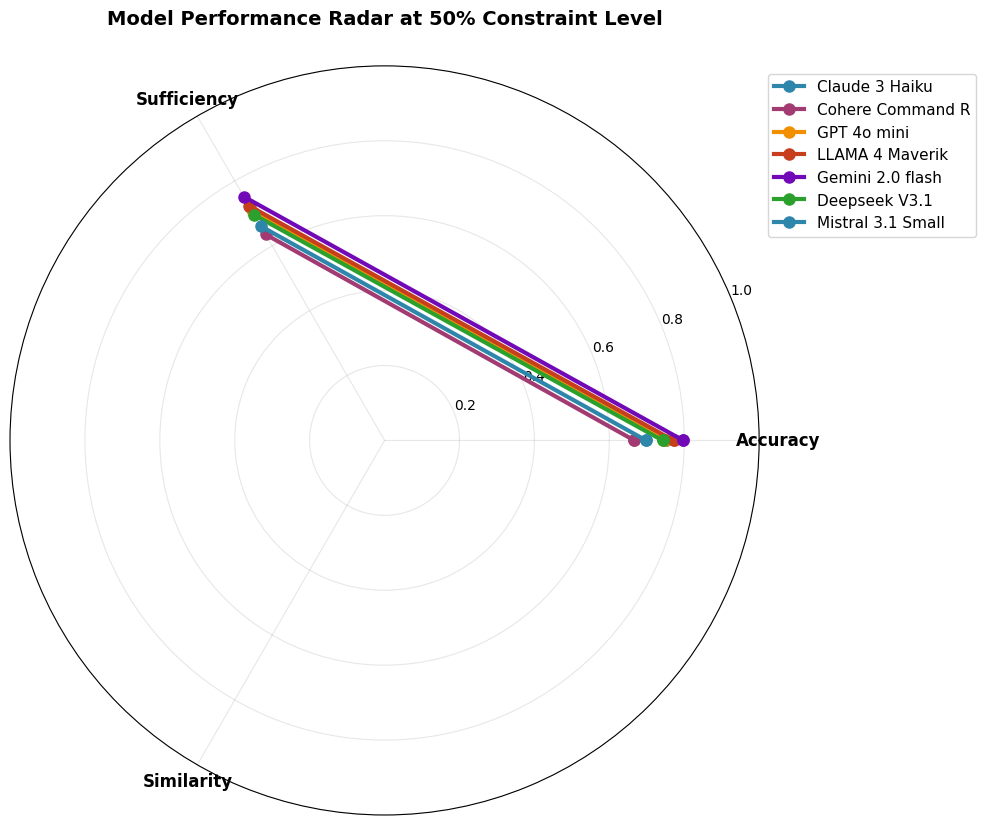

In [14]:
plot_radar_comparison(dfs)

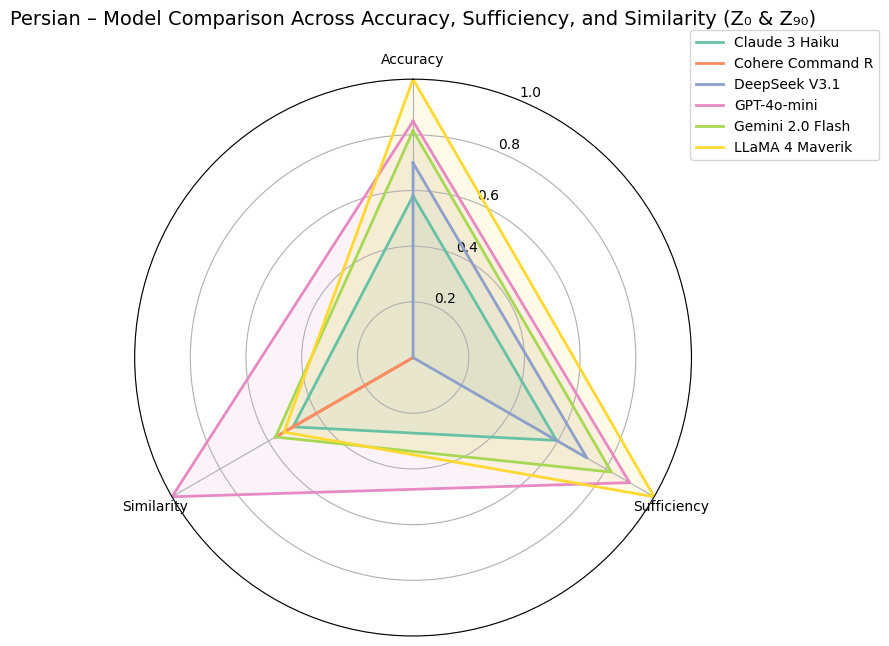

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==========================================
# Persian radar data (acc/suff @ Z0, sim @ Z90)
# ==========================================
data_fa = {
    "Model": [
        "Claude 3 Haiku",
        "Cohere Command R",
        "DeepSeek V3.1",
        "GPT-4o-mini",
        "Gemini 2.0 Flash",
        "LLaMA 4 Maverik"
    ],
    "Accuracy": [0.7838, 0.6924, 0.8024, 0.8260, 0.8206, 0.8497],
    "Sufficiency": [0.7478, 0.6612, 0.7661, 0.7919, 0.7809, 0.8067],
    "Similarity": [0.8683, 0.8734, 0.8341, 0.9028, 0.8733, 0.8709]
}

df = pd.DataFrame(data_fa)

# ==========================================
# Radar chart setup
# ==========================================
categories = ["Accuracy", "Sufficiency", "Similarity"]
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

# normalize for fair comparison
df[categories] = df[categories].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in df.iterrows():
    values = row[categories].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=row["Model"])
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), categories)
ax.set_ylim(0, 1)
ax.set_title("Persian – Model Comparison Across Accuracy, Sufficiency, and Similarity (Z₀ & Z₉₀)", size=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1))
plt.tight_layout()
plt.show()


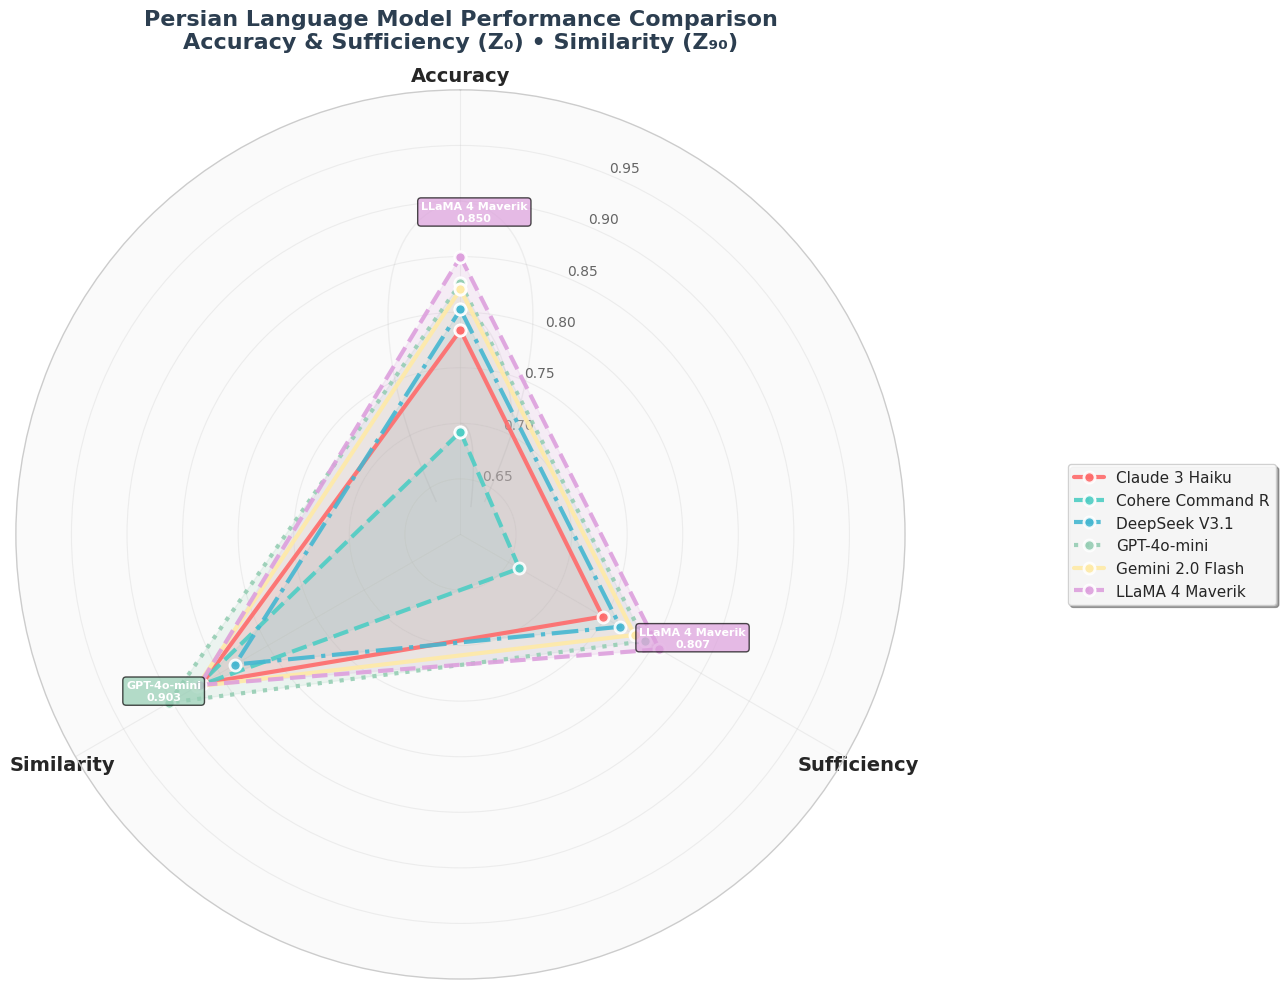

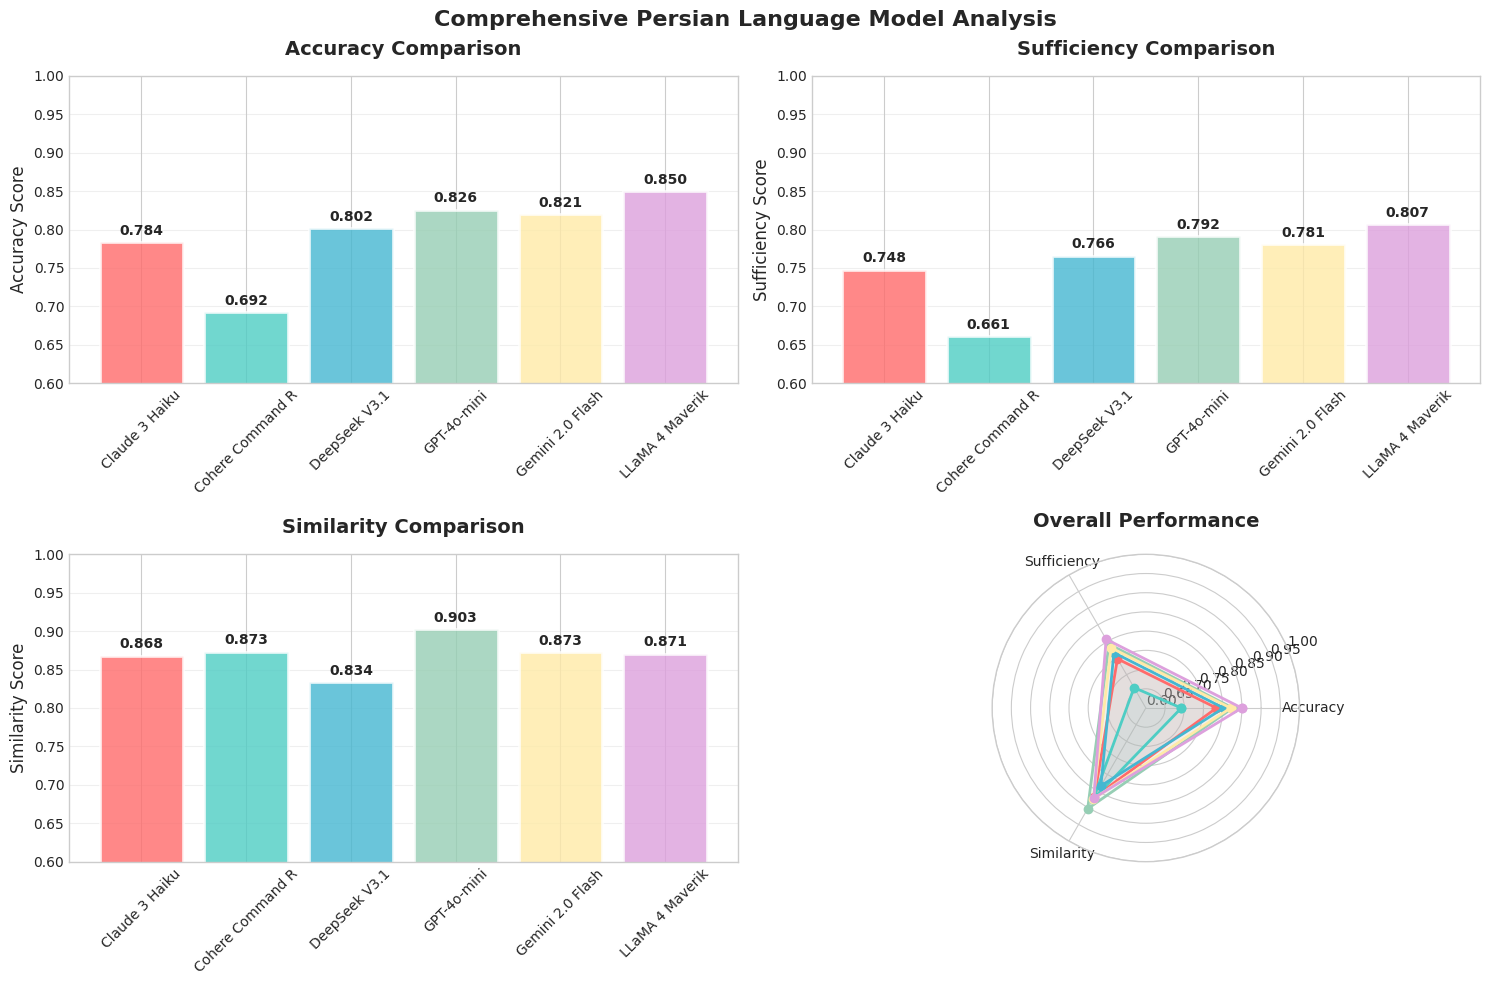

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Circle
import seaborn as sns

# Set style for better aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ==========================================
# Persian radar data (acc/suff @ Z0, sim @ Z90)
# ==========================================
data_fa = {
    "Model": [
        "Claude 3 Haiku",
        "Cohere Command R", 
        "DeepSeek V3.1",
        "GPT-4o-mini",
        "Gemini 2.0 Flash",
        "LLaMA 4 Maverik"
    ],
    "Accuracy": [0.7838, 0.6924, 0.8024, 0.8260, 0.8206, 0.8497],
    "Sufficiency": [0.7478, 0.6612, 0.7661, 0.7919, 0.7809, 0.8067],
    "Similarity": [0.8683, 0.8734, 0.8341, 0.9028, 0.8733, 0.8709]
}

df = pd.DataFrame(data_fa)

# ==========================================
# Enhanced Radar chart setup
# ==========================================
categories = ["Accuracy", "Sufficiency", "Similarity"]
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

# Create figure with larger size and better DPI
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True), dpi=100)

# Define beautiful color palette
colors = [
    '#FF6B6B',  # Coral Red
    '#4ECDC4',  # Teal
    '#45B7D1',  # Sky Blue  
    '#96CEB4',  # Mint Green
    '#FFEAA7',  # Warm Yellow
    '#DDA0DD'   # Plum
]

# Line styles for better distinction
line_styles = ['-', '--', '-.', ':', '-', '--']
line_widths = [3, 3, 3, 3, 3, 3]

# Plot each model with enhanced styling
for i, row in df.iterrows():
    values = row[categories].tolist()
    values += values[:1]
    
    ax.plot(angles, values, 
           linewidth=line_widths[i], 
           linestyle=line_styles[i], 
           label=row["Model"],
           color=colors[i],
           marker='o',
           markersize=8,
           markerfacecolor=colors[i],
           markeredgecolor='white',
           markeredgewidth=2,
           alpha=0.9)
    
    ax.fill(angles, values, alpha=0.15, color=colors[i])

# Customize the radar chart appearance
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Set category labels with better formatting
ax.set_thetagrids(np.degrees(angles[:-1]), categories, fontsize=14, fontweight='bold')

# Customize radial limits and grid
ax.set_ylim(0.6, 1.0)  # Focus on the actual data range
ax.set_yticks([0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
ax.set_yticklabels(['0.65', '0.70', '0.75', '0.80', '0.85', '0.90', '0.95'], 
                   fontsize=10, alpha=0.7)

# Add grid styling
ax.grid(True, alpha=0.3)
ax.set_facecolor('#FAFAFA')

# Enhanced title with better positioning
ax.set_title("Persian Language Model Performance Comparison\nAccuracy & Sufficiency (Z₀) • Similarity (Z₉₀)", 
            size=16, fontweight='bold', pad=30, color='#2C3E50')

# Improved legend with better positioning
legend = ax.legend(loc='center', bbox_to_anchor=(1.3, 0.5), 
                  fontsize=11, frameon=True, fancybox=True, 
                  shadow=True, framealpha=0.9)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('#CCCCCC')

# Add subtle background circles for better visual reference
for radius in [0.7, 0.8, 0.9]:
    circle = Circle((0, 0), radius, fill=False, color='gray', alpha=0.1, linewidth=1)
    ax.add_patch(circle)

# Add performance annotations for top performers
max_values = df[categories].max()
for i, category in enumerate(categories):
    max_idx = df[category].idxmax()
    max_model = df.loc[max_idx, 'Model']
    max_val = df.loc[max_idx, category]
    
    # Add small annotation for best performer in each category
    angle_rad = angles[i]
    x_pos = angle_rad
    y_pos = max_val + 0.02
    
    ax.annotate(f'{max_model}\n{max_val:.3f}', 
               xy=(x_pos, y_pos), 
               xytext=(10, 10), 
               textcoords='offset points',
               fontsize=8, 
               ha='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[max_idx], alpha=0.7),
               color='white',
               fontweight='bold')

plt.tight_layout()



plt.show()

# ==========================================
# Alternative: Create a comparison bar chart as well
# ==========================================
fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Individual metric comparisons
metrics = ['Accuracy', 'Sufficiency', 'Similarity']
for idx, metric in enumerate(metrics):
    if idx < 3:
        current_ax = [ax1, ax2, ax3][idx]
        bars = current_ax.bar(df['Model'], df[metric], color=colors, alpha=0.8, edgecolor='white', linewidth=2)
        current_ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold', pad=15)
        current_ax.set_ylabel(f'{metric} Score', fontsize=12)
        current_ax.set_ylim(0.6, 1.0)
        current_ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            current_ax.annotate(f'{height:.3f}',
                              xy=(bar.get_x() + bar.get_width() / 2, height),
                              xytext=(0, 3),
                              textcoords="offset points",
                              ha='center', va='bottom',
                              fontweight='bold', fontsize=10)
        
        current_ax.tick_params(axis='x', rotation=45)

# Overall performance radar in the 4th subplot
ax4.remove()
ax4 = fig2.add_subplot(2, 2, 4, polar=True)

# Compute overall scores
df['Overall'] = df[categories].mean(axis=1)

for i, row in df.iterrows():
    values = row[categories].tolist()
    values += values[:1]
    ax4.plot(angles, values, linewidth=2, label=row["Model"], color=colors[i], marker='o')
    ax4.fill(angles, values, alpha=0.1, color=colors[i])

ax4.set_thetagrids(np.degrees(angles[:-1]), categories, fontsize=10)
ax4.set_title("Overall Performance", fontsize=14, fontweight='bold', pad=20)
ax4.set_ylim(0.6, 1.0)

plt.suptitle('Comprehensive Persian Language Model Analysis', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [14]:
merged_wide = (
    merged_df
    .pivot(index="version", columns="model", values=["accuracy_exp", "sufficiency", "similarity_clean"])
)

merged_wide

accuracy_exp                                             \
model   Claude 3 Haiku Cohere Command R Deepseek V3.1 GPT 4o mini   
version                                                             
0             0.783805         0.692367      0.802402    0.826036   
10            0.688493         0.613328      0.667571    0.645486   
20            0.719101         0.631926      0.693142    0.679194   
30            0.745060         0.648586      0.717939    0.710190   
40            0.749322         0.672220      0.728787    0.731112   
50            0.750872         0.666796      0.742348    0.749709   
60            0.760558         0.670670      0.738473    0.753584   
70            0.765595         0.675707      0.747385    0.767532   
80            0.765207         0.683069      0.759008    0.775668   
90            0.764820         0.680356      0.767532    0.782255   

                                            sufficiency                   \
model   Gemini 2.0 flash LLAMA 4 Maverik Claude 3 Haiku Cohere Command R   
version                                                                    
0               0.820612        0.849671       0.747764         0.661227   
10              0.692755        0.653623       0.651099         0.576517   
20              0.736149        0.704766       0.685721         0.601882   
30              0.760558        0.735374       0.708011         0.617286   
40              0.781480        0.755909       0.716315         0.633912   
50              0.797365        0.771406       0.720418         0.635008   
60              0.800852        0.777606       0.724539         0.637668   
70              0.807826        0.773731       0.728309         0.644664   
80              0.803177        0.791166       0.729720         0.649870   
90              0.809764        0.796203       0.728880         0.648612   

                                                                    \
model   Deepseek V3.1 GPT 4o mini Gemini 2.0 flash LLAMA 4 Maverik   
version                                                              
0            0.766077    0.791861         0.780864        0.806687   
10           0.621031    0.607502         0.650338        0.612349   
20           0.649168    0.635490         0.693264        0.657773   
30           0.670463    0.668659         0.718593        0.688907   
40           0.685542    0.688366         0.740963        0.708394   
50           0.694888    0.703853         0.751521        0.722975   
60           0.699196    0.714209         0.758141        0.730638   
70           0.703200    0.726096         0.763811        0.735538   
80           0.713849    0.736458         0.765482        0.746862   
90           0.721202    0.744429         0.768477        0.749993   

        similarity_clean                                             \
model     Claude 3 Haiku Cohere Command R Deepseek V3.1 GPT 4o mini   
version                                                               
0                    NaN              NaN           NaN         NaN   
10              0.641761         0.525559      0.570013    0.584329   
20              0.746146         0.656978      0.654810    0.676961   
30              0.796191         0.729514      0.707658    0.742607   
40              0.826505         0.777698      0.743207    0.794435   
50              0.844635         0.807805      0.772465    0.831390   
60              0.851756         0.827879      0.789537    0.855248   
70              0.854943         0.845101      0.805601    0.872703   
80              0.862874         0.860100      0.820477    0.888897   
90              0.868333         0.873420      0.834147    0.902828   

                                          
model   Gemini 2.0 flash LLAMA 4 Maverik  
version                                   
0                    NaN             NaN  
10              0.557314        0.547995  
20              0.692414        0.674266  
30              0.768547      

In [24]:
import pandas as pd

all_dfs = []
for model_name, df in dfs.items():
    # فقط ستون‌های لازم رو نگه می‌داریم
    sub = df[["version", "accuracy_exp", "sufficiency", "similarity_clean"]].copy()
    sub["model"] = model_name   # اضافه کردن نام مدل
    all_dfs.append(sub)

# ادغام همه دیتافریم‌ها
merged_df = pd.concat(all_dfs, ignore_index=True)

merged_df.head()


,version,accuracy_exp,sufficiency,similarity_clean,model
0,0,0.783805,0.747764,NaN,Claude 3 Haiku
1,10,0.688493,0.651099,0.641761,Claude 3 Haiku
2,20,0.719101,0.685721,0.746146,Claude 3 Haiku
3,30,0.745060,0.708011,0.796191,Claude 3 Haiku
4,40,0.749322,0.716315,0.826505,Claude 3 Haiku


                  accuracy_exp  sufficiency  similarity_clean
accuracy_exp          1.000000     0.946297          0.560140
sufficiency           0.946297     1.000000          0.590496
similarity_clean      0.560140     0.590496          1.000000


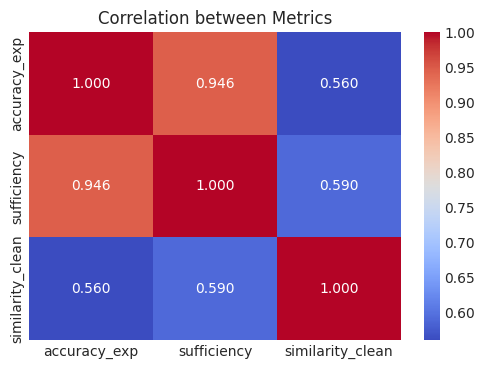

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# محاسبه ماتریس همبستگی
corr = merged_df[["accuracy_exp", "sufficiency", "similarity_clean"]].corr(method="kendall")
print(corr)

# نمایش بصری
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Correlation between Metrics")
plt.show()


In [37]:
import pandas as pd
df = pd.read_csv('/home/a_zahedzadeh/self-explaination-thesis/results/models/evaluation/qwen_1.7B/fa_with_goldprob/llama/eval_llama_4_maverik_masked_80_with_goldprob.csv')

In [41]:
corr_rows = df[["is_correct_exp", "gold_prob_exp"]].corr('pearson')
print("\nRow-level correlation:\n", corr_rows)


Row-level correlation:
                 is_correct_exp  gold_prob_exp
is_correct_exp        1.000000       0.910536
gold_prob_exp         0.910536       1.000000


In [42]:
# Pearson (default)
pearson_corr = df[["is_correct_exp", "gold_prob_exp"]].corr(method="pearson")
print("Pearson:\n", pearson_corr)

# Spearman
spearman_corr = df[["is_correct_exp", "gold_prob_exp"]].corr(method="spearman")
print("\nSpearman:\n", spearman_corr)

# Kendall
kendall_corr = df[["is_correct_exp", "gold_prob_exp"]].corr(method="kendall")
print("\nKendall:\n", kendall_corr)


Pearson:
                 is_correct_exp  gold_prob_exp
is_correct_exp        1.000000       0.910536
gold_prob_exp         0.910536       1.000000

Spearman:
                 is_correct_exp  gold_prob_exp
is_correct_exp        1.000000       0.702489
gold_prob_exp         0.702489       1.000000

Kendall:
                 is_correct_exp  gold_prob_exp
is_correct_exp        1.000000       0.573692
gold_prob_exp         0.573692       1.000000
